In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install dice_ml -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 51.8 MB/s eta 0:00:00


In [4]:
! pip install eli5 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F

import sklearn
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import xgboost as xgb
from xgboost import XGBClassifier

from eli5 import show_weights
from eli5 import show_prediction
from eli5 import explain_weights_xgboost
from eli5 import explain_prediction_xgboost

import dice_ml
from dice_ml import Dice

from IPython.display import display

## MLP using Pytorch

In [ ]:
data_path = '/content/drive/MyDrive/Malware Visualization/Dataset/completeFeaturesTrainDataset.csv'

df = pd.read_csv(data_path)

In [ ]:
class MalwareDataset(Dataset):
    def __init__(self, df):
        self.data = df.iloc[:, :-1].values
        self.targets = df.iloc[:, -1].values
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return torch.tensor(x).float(), torch.tensor(y)

In [ ]:
df['Class'] = df['Class'] - 1
data = MalwareDataset(df.drop(['ID'], axis=1))

In [ ]:
valid_size = 0.2 # percentage of training set to use as validation
batch_size = 32 # size of the batch

# obtain training indices that will be used for validation
indices = list(range(len(data)))
np.random.shuffle(indices)
split = int(np.floor(valid_size * len(data)))
train_index, valid_index = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, sampler = valid_sampler)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [ ]:
class NeuralNetwork(nn.Module):  
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.fc1 = nn.Linear(259, 512) # linear layer (259 -> 512)
        self.fc2 = nn.Linear(512, 512) # linear layer (512 -> 512)
        self.fc3 = nn.Linear(512, 9) # linear layer (512 -> 9)
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x

In [ ]:
class DeeperNeuralNetwork(nn.Module):  
    def __init__(self):
        super(DeeperNeuralNetwork,self).__init__()
        self.fc1 = nn.Linear(259, 512) # linear layer (259 -> 512)
        self.fc2 = nn.Linear(512, 1024) # linear layer (512 -> 1024)
        self.fc3 = nn.Linear(1024, 512) # linear layer (1024 -> 512)
        self.fc4 = nn.Linear(512, 9) # linear layer (512 -> 9)
        self.drop = nn.Dropout(0.5)
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(self.drop(x))
        x = F.relu(x)
        x = self.fc3(self.drop(x))
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [ ]:
def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, model_path, valid_loss_min=np.Inf, scheduler=0):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0 # monitor losses
      
      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          optimizer.zero_grad() # clear the gradients of all optimized variables
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
          loss = criterion(output, label) # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)
          train_loss += loss.item() * data.size(0) # update running training loss
          if not(scheduler==0):
            scheduler.step()
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          with torch.no_grad():
              output = model(data)
          loss = criterion(output,label)
          valid_loss += loss.item() * data.size(0)
      
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), model_path)
          valid_loss_min = valid_loss
      
  return train_losses, valid_losses      

In [ ]:
def evaluation(model, test_loader, criterion):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(9))
  class_total = list(0. for i in range(9))

  model.eval() # prep model for evaluation
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1) # convert output probabilities to predicted class
      correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(9):
      print('test accuracy of %1s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [ ]:
model = NeuralNetwork()
model.to(device=device)
epochs = 1000

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses, valid_losses = training(epochs, train_loader, valid_loader, model, criterion, optimizer, '/content/drive/MyDrive/Malware Visualization/Models/Model.pt', valid_loss_min=0.643414)

epoch: 1 	training Loss: 0.645615 	validation Loss: 0.662092
epoch: 2 	training Loss: 0.658404 	validation Loss: 0.859189
epoch: 3 	training Loss: 0.660413 	validation Loss: 0.729246
epoch: 4 	training Loss: 0.629919 	validation Loss: 0.674642
epoch: 5 	training Loss: 0.637244 	validation Loss: 0.742321
epoch: 6 	training Loss: 0.616342 	validation Loss: 0.788382
epoch: 7 	training Loss: 0.619323 	validation Loss: 0.770769
epoch: 8 	training Loss: 0.626814 	validation Loss: 0.966909
epoch: 9 	training Loss: 2.266881 	validation Loss: 0.738694
epoch: 10 	training Loss: 0.612387 	validation Loss: 0.756556
epoch: 11 	training Loss: 0.617013 	validation Loss: 0.705260
epoch: 12 	training Loss: 0.613486 	validation Loss: 0.741301
epoch: 13 	training Loss: 0.605147 	validation Loss: 0.726750
epoch: 14 	training Loss: 0.609531 	validation Loss: 0.712635
epoch: 15 	training Loss: 0.626527 	validation Loss: 0.755923
epoch: 16 	training Loss: 0.614444 	validation Loss: 0.947336
epoch: 17 	traini

KeyboardInterrupt: ignored

In [ ]:
check_point = torch.load('/content/drive/MyDrive/Malware Visualization/Models/Model.pt', map_location=device)
model.load_state_dict(check_point)

<All keys matched successfully>

In [ ]:
evaluation(model, valid_loader, criterion)

test Loss: 0.597271

test accuracy of 0: 94% (281/297)
test accuracy of 1: 94% (466/493)
test accuracy of 2: 99% (605/607)
test accuracy of 3: 22% (18/81)
test accuracy of 4:  0% ( 0/ 8)
test accuracy of 5: 16% (26/156)
test accuracy of 6: 78% (60/76)
test accuracy of 7: 93% (212/227)
test accuracy of 8:  0% ( 0/228)

test accuracy (overall): 76.76% (1668/2173)


In [ ]:
deep_model = DeeperNeuralNetwork()
deep_model.to(device=device)
epochs = 1000

criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(deep_model.parameters(), lr=0.0001)

In [ ]:
train_losses, valid_losses = training(epochs, train_loader, valid_loader, deep_model, criterion, optimizer, '/content/drive/MyDrive/Malware Visualization/Models/DeeperModel.pt', valid_loss_min=0.664058)

epoch: 1 	training Loss: 1.065746 	validation Loss: 0.639478
validation loss decreased (0.664058 --> 0.639478).  Saving model ...
epoch: 2 	training Loss: 0.839183 	validation Loss: 0.639640
epoch: 3 	training Loss: 1.161533 	validation Loss: 0.651715
epoch: 4 	training Loss: 1.246852 	validation Loss: 0.690688
epoch: 5 	training Loss: 0.859921 	validation Loss: 0.622167
validation loss decreased (0.639478 --> 0.622167).  Saving model ...
epoch: 6 	training Loss: 0.990012 	validation Loss: 0.674638
epoch: 7 	training Loss: 0.724902 	validation Loss: 0.648518
epoch: 8 	training Loss: 0.818338 	validation Loss: 0.677207
epoch: 9 	training Loss: 0.958253 	validation Loss: 0.698058
epoch: 10 	training Loss: 0.787220 	validation Loss: 0.655205
epoch: 11 	training Loss: 0.727339 	validation Loss: 0.666853
epoch: 12 	training Loss: 1.015550 	validation Loss: 0.687338
epoch: 13 	training Loss: 0.687419 	validation Loss: 0.679006
epoch: 14 	training Loss: 0.634684 	validation Loss: 0.625996
epo

In [ ]:
check_point = torch.load('/content/drive/MyDrive/Malware Visualization/Models/DeeperModel.pt', map_location=device)
deep_model.load_state_dict(check_point)

<All keys matched successfully>

In [ ]:
evaluation(deep_model, valid_loader, criterion)

test Loss: 0.393340

test accuracy of 0: 93% (300/320)
test accuracy of 1: 98% (494/501)
test accuracy of 2: 100% (560/560)
test accuracy of 3: 81% (82/101)
test accuracy of 4:  0% ( 0/ 8)
test accuracy of 5: 85% (124/145)
test accuracy of 6:  0% ( 0/89)
test accuracy of 7: 91% (221/242)
test accuracy of 8: 98% (203/207)

test accuracy (overall): 91.30% (1984/2173)


## XGBoost

### Basic Model

In [6]:
def get_weights(cls):
    class_weights = {
        0: 1,
        1: 1,
        2: 1,
        3: 1,
        4: 4,
        5: 1,
        6: 1,
        7: 1,
        8: 1,
    }

    return [class_weights[cl] for cl in cls]

In [7]:
data_path = '/content/drive/MyDrive/Malware Visualization/Dataset/completeFeaturesTrainDataset.csv'
df = pd.read_csv(data_path)

y = df['Class']-1
X = df.drop(['ID', 'Class'], axis=1)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y,train_size=0.7)

print("Train dataset shape:", X_train.shape)
print("Validation dataset shape:", X_val.shape)

Train dataset shape: (7607, 259)
Validation dataset shape: (3261, 259)


In [ ]:
xgb1 = XGBClassifier(random_state=42, n_jobs=-1)
xgb1.fit(X_train, y_train, sample_weight=get_weights(y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
train_acc = xgb.score(X_train, y_train)
test_acc = xgb.score(X_val, y_val)

print("Train accuracy:", round(train_acc, 4))
print("Test accuracy:", round(test_acc, 4))

Train accuracy: 1.0
Test accuracy: 0.9844


In [ ]:
xgb.save_model("/content/drive/MyDrive/Malware Visualization/Models/XGBModelWithoutFineTuning.json")

### Fine Tuning

In [ ]:
def get_log_loss(kwargs):
    xgb_clf = XGBClassifier(random_state=42, n_jobs=-1, **kwargs)
    xgb_clf.fit(X_train, y_train)

    y_train_probs = xgb_clf.predict_proba(X_train)
    train_ll = log_loss(y_train, y_train_probs)

    y_test_probs = xgb_clf.predict_proba(X_val)
    test_ll = log_loss(y_val, y_test_probs)

    return train_ll, test_ll


def hyperparameter_tuning(**kwargs):
    train_errs = []
    test_errs = []

    params = list(kwargs.items())
    hypr_params = dict(params[0:-1])
    # Get the last item with range.
    param_key, range_vals = params[-1]

    for param_val in range_vals:
        hypr_params[param_key] = param_val
        train_err, test_err = get_log_loss(hypr_params)
        train_errs.append(train_err)
        test_errs.append(test_err)

    plt.figure(figsize=(10, 8))

    sns.lineplot(x=range_vals, y=train_errs, label="Train error")
    sns.lineplot(x=range_vals, y=test_errs, label="Validation error")
    plt.title(f"Param: `{param_key}`")
    plt.xlabel("Value")
    plt.ylabel("Log Loss")
    plt.xticks(range_vals)

    plt.show()

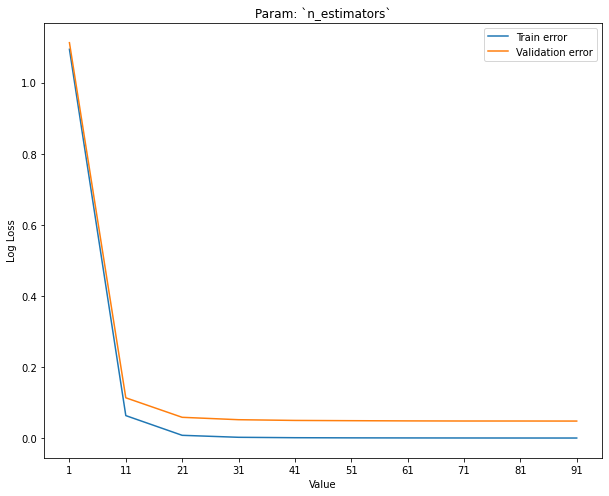

In [ ]:
hyperparameter_tuning(n_estimators=range(1, 100, 10))

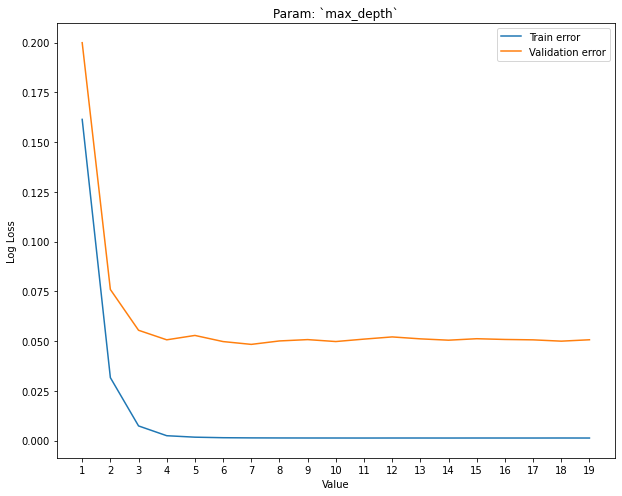

In [ ]:
hyperparameter_tuning(n_estimators=50, max_depth=range(1, 20))

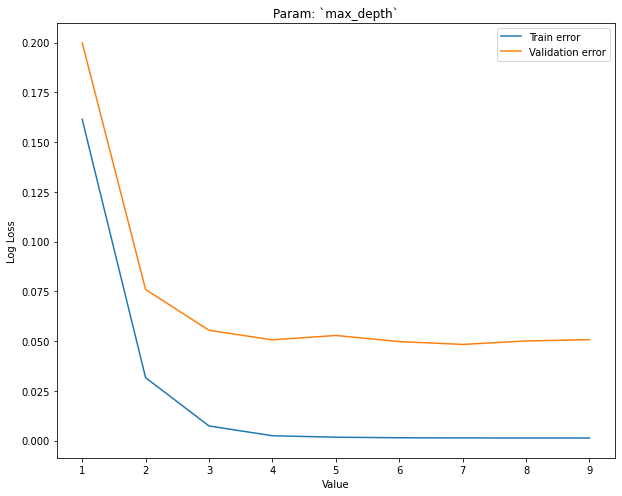

In [ ]:
hyperparameter_tuning(n_estimators=50, max_depth=range(1, 10))

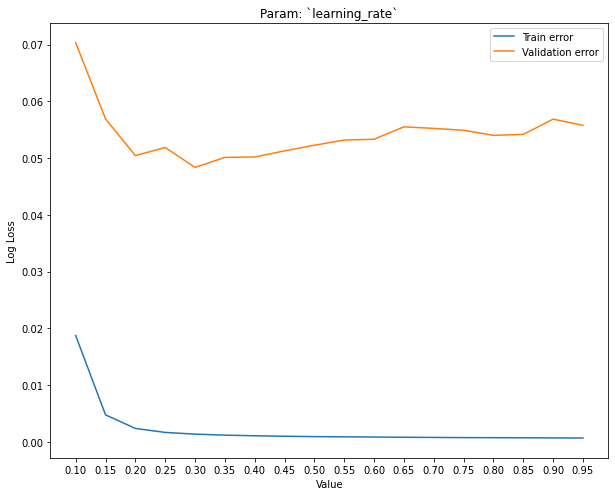

In [ ]:
hyperparameter_tuning(max_depth=7, n_estimators=50, learning_rate=np.arange(0.1, 1.0, 0.05))

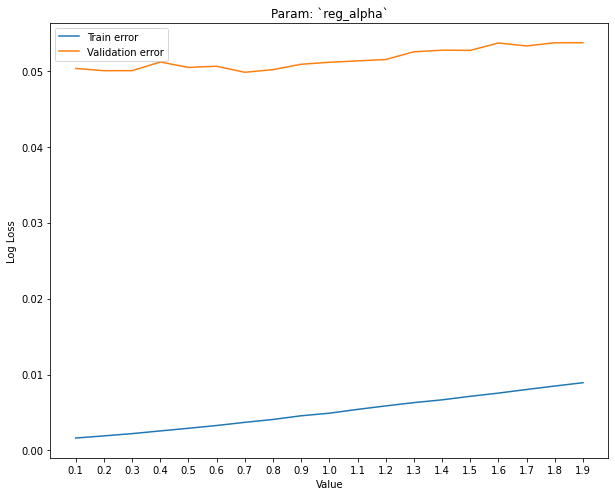

In [ ]:
hyperparameter_tuning(
    max_depth=7,
    n_estimators=50,
    learning_rate=0.3,
    reg_alpha=np.arange(0.1, 2, 0.1),
)

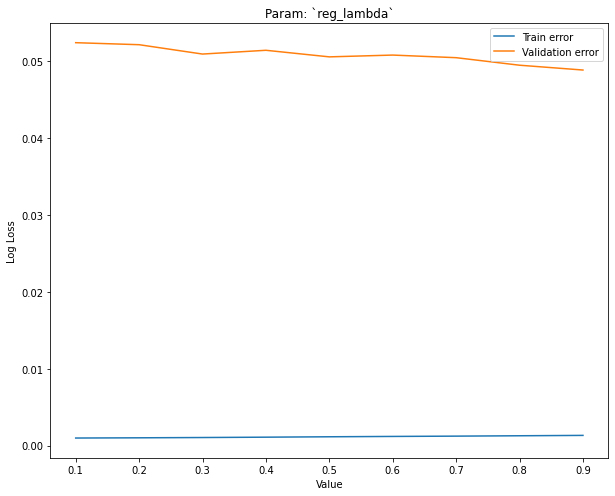

In [ ]:
hyperparameter_tuning(
    max_depth=7,
    n_estimators=50,
    learning_rate=0.3,
    reg_lambda=np.arange(0.1, 1, 0.1),
)

In [8]:
best_xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.3, random_state=42, n_jobs=-1)
best_xgb.fit(X_train, y_train, sample_weight=get_weights(y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [9]:
train_acc = best_xgb.score(X_train, y_train)
test_acc = best_xgb.score(X_val, y_val)

print("Train accuracy:", round(train_acc, 4))
print("Test accuracy:", round(test_acc, 4))

Train accuracy: 1.0
Test accuracy: 0.9847


In [ ]:
best_xgb.save_model("/content/drive/MyDrive/Malware Visualization/Models/BestXGBModelWithFineTuning.json")

### Explainability

In [9]:
y_train

70      8
6490    2
1197    1
6846    8
9108    2
       ..
4472    2
3023    7
9557    2
9334    8
7187    3
Name: Class, Length: 7607, dtype: int64

In [ ]:
df

,Unnamed: 0,ID,0,1,2,3,4,5,6,7,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,...,3101,3211,3097,2758,3099,2759,5753,1824,4.234863,9
1,1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,...,439,281,302,7639,518,17001,54902,8588,5.538818,2
2,2,01jsnpXSAlgw6aPeDxrU,93506,9542,2568,2438,8925,9330,9007,2342,...,2242,2885,2863,2471,2786,2680,49144,468,3.887939,9
3,3,01kcPWA9K2BOxQeS5Rju,21091,1213,726,817,1257,625,550,523,...,485,462,516,1133,471,761,7998,13940,0.574219,1
4,4,01SuzwMJEIXsK7A8dQbl,19764,710,302,433,559,410,262,249,...,350,209,239,653,221,242,2199,9008,0.370850,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10863,10863,loIP1tiwELF9YNZQjSUO,5268,1177,1072,1222,1238,1159,1143,1126,...,1094,1154,1088,1113,1114,1107,1178,347816,1.878174,4
10864,10864,LOP6HaJKXpkic5dyuVnT,3032,298,248,293,274,213,203,222,...,202,202,215,208,195,196,336,14368,0.215332,4
10865,10865,LOqA6FX02GWguYrI1Zbe,5671,221,270,323,313,155,248,147,...,159,247,163,249,149,226,231,11396,0.215332,4
10866,10866,LoWgaidpb2IUM5ACcSGO,3637,437,453,506,511,390,431,407,...,377,376,352,543,361,330,440,85540,0.550293,4


In [9]:
best_xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.3, random_state=42, n_jobs=-1)
best_xgb.fit(X_train, y_train, sample_weight=get_weights(y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [10]:
display(show_weights(best_xgb))

Weight,Feature
0.1000,1b
0.0769,31
0.0661,33
0.0556,6
0.0454,f7
0.0442,9a
0.0372,c7
0.0233,b6
0.0221,??
0.0177,8b


In [27]:
show_prediction(best_xgb, X_val.iloc[2])

In [33]:
pred_weights = explain_prediction_xgboost(best_xgb, X_val.iloc[2], top=5)
string_pred = str(pred_weights)[12:-1].split('\\n')
target_pred_weigths = string_pred[30][61:].split('TargetExplanation')[1:]
target_pred_weigths = ''.join(target_pred_weigths)

target_pred_weigths = target_pred_weigths.split('(target=')[1:]
features = target_pred_weigths[2]
print(features.split('feature='))

#for class_feature in target_pred_weigths:
    #class_feature = class_feature.split(', feature_weights=FeatureWeights(')
    # print(class_feature)
    #proba = class_feature[1].split('proba=')[1].split(', ')[0]
    # print('Proba:', proba)

# print(target_pred_weigths)

2, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='??', weight=2.7076344269202597, std=None, value=1498268.0), FeatureWeight(feature='<BIAS>', weight=2.026484043617341, std=None, value=1.0), FeatureWeight(feature='ab', weight=0.4805621270455818, std=None, value=3249.0), FeatureWeight(feature='ad', weight=0.2571960240906374, std=None, value=3204.0), FeatureWeight(feature='91', weight=0.24431993132929095, std=None, value=3186.0)], neg=[], pos_remaining=18, neg_remaining=0), proba=0.9998673, score=6.88524235582, weighted_spans=None, heatmap=None), 


### Counterfactual Explanation

In [ ]:
data_path = '/content/drive/MyDrive/Malware Visualization/Dataset/completeFeaturesTrainDataset.csv'
df = pd.read_csv(data_path)

outcome_name = 'Class'
continuous_features_iris = df.drop(outcome_name, axis=1).columns.tolist()
target = df[outcome_name]-1

In [ ]:
data_path = '/content/drive/MyDrive/Malware Visualization/Dataset/completeFeaturesTrainDataset.csv'
df = pd.read_csv(data_path)

y = df['Class']-1
X = df.drop(['ID', 'Class'], axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True,train_size=0.7)

print("Train dataset shape:", X_train.shape)
print("Validation dataset shape:", X_val.shape)

Train dataset shape: (7607, 259)
Validation dataset shape: (3261, 259)


In [ ]:
best_xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.3, random_state=42, n_jobs=-1)
best_xgb.fit(X_train, y_train, sample_weight=get_weights(y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
continuous_features = df.drop(['ID', 'Class'], axis=1).columns.tolist()

dice = dice_ml.Data(dataframe=df.drop(['ID'], axis=1),
                      continuous_features=continuous_features,
                      outcome_name=outcome_name)

# We provide the type of model as a parameter (model_type)
m_dice = dice_ml.Model(model=best_xgb, backend='sklearn', model_type='classifier')

In [ ]:
exp_genetic = Dice(dice, m_dice, method="genetic")

In [ ]:
# Single input
query_instances = X_val[2:3] # X_val[2] --> Class = 6
cf_exemple = exp_genetic.generate_counterfactuals(query_instances, total_CFs=7, desired_class=6)
cf_exemple.visualize_as_dataframe()

100%|██████████| 1/1 [00:02<00:00,  2.67s/it]

Query instance (original outcome : 6)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,6386.0,175902.0,4989.0,2584.0,4099.0,4249.0,2273.0,1972.0,4311.0,2509.0,...,1383.0,1708.0,1606.0,1681.0,1446.0,1500.0,15906.0,613664.0,3.708496,6



Diverse Counterfactual set (new outcome: 6)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,6386.0,175902.0,4989.0,2584.0,4099.0,4249.0,2273.0,1972.0,4311.0,2509.0,...,1383.0,1708.0,1606.0,1681.0,1446.0,1500.0,15906.0,613664.0,3.708496,6
0,3804.0,175426.0,4472.0,137614.0,90.0,8380.0,1983.0,1582.0,0.0,7926.0,...,1891.0,57.0,1664.0,0.0,0.0,37.0,0.0,618292.0,3.720459,6
0,3586.0,175426.0,4472.0,2159.0,3237.0,3686.0,1983.0,1582.0,3613.0,2004.0,...,1891.0,1915.0,1664.0,1785.0,1950.0,1566.0,15973.0,618292.0,3.720459,6
0,5618.0,176321.0,4584.0,2505.0,3655.0,3616.0,2030.0,1809.0,3807.0,2201.0,...,1516.0,1670.0,1425.0,1718.0,1291.0,1695.0,15981.0,621364.0,3.732422,6
0,0.0,249645.0,3386.0,33.0,3237.0,0.0,22.0,0.0,3613.0,0.0,...,74.0,52.0,0.0,0.0,8.0,109.0,0.0,0.0,3.720459,6
0,0.0,175426.0,3394.0,3829.0,3237.0,0.0,0.0,0.0,3613.0,2004.0,...,74.0,52.0,1664.0,1785.0,2.0,109.0,1213.0,440696.0,3.720459,6
0,2531.0,175841.0,4278.0,2434.0,3467.0,0.0,2127.0,0.0,0.0,2106.0,...,0.0,0.0,1388.0,1763.0,0.0,2029.0,15638.0,646936.0,3.696533,6


In [ ]:
# Save generated counterfactual examples to disk
cf_exemple.cf_examples_list[0].final_cfs_df.to_csv(path_or_buf='/content/drive/MyDrive/Malware Visualization/Dataset/counterfactualsClass6.csv', index=False)

In [ ]:
cf_exemple_class_6 = pd.read_csv('/content/drive/MyDrive/Malware Visualization/Dataset/counterfactualsClass6.csv')
X_cf_exemple_class_6 = cf_exemple_class_6.drop(['Class'], axis=1)

data_cf_exemple_class_6 = xgb.DMatrix(X_cf_exemple_class_6)

In [ ]:
y_pred_cf_exemple_class_6 = model.predict(data_cf_exemple_class_6)
for i in range(len(y_pred_cf_exemple_class_6)):
    max_index = np.argmax(y_pred_cf_exemple_class_6[i])
    print("Index of max value for element {}:".format(i), max_index)

Index of max value for element 0: 6
Index of max value for element 1: 6
Index of max value for element 2: 6
Index of max value for element 3: 6
Index of max value for element 4: 6
Index of max value for element 5: 6
Index of max value for element 6: 6


### Counterfactual examples for two class (2 and 3 here) 

In [ ]:
data_path = '/content/drive/MyDrive/Malware Visualization/Dataset/completeFeaturesTrainDataset.csv'
df = pd.read_csv(data_path)

y = df['Class']-1
X = df.drop(['ID', 'Class'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True,train_size=0.7)

In [ ]:
best_xgb = XGBClassifier(n_estimators=50, max_depth=7, learning_rate=0.3, random_state=42, n_jobs=-1)
best_xgb.fit(X_train, y_train, sample_weight=get_weights(y_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
first_class = 2
second_class = 3

df_first_class = df.loc[df['Class'] == first_class]
X_first_class = df_first_class.drop(['ID', 'Class'], axis=1)

df_second_class = df.loc[df['Class'] == second_class]
X_second_class = df_second_class.drop(['ID', 'Class'], axis=1)

# size = min(df_firs_class.shape[0], df_second_class.shape[0])

In [ ]:
outcome_name = 'Class'
target = df[outcome_name]-1

continuous_features = df.drop(['ID', 'Class'], axis=1).columns.tolist()

dice = dice_ml.Data(dataframe=df.drop(['ID'], axis=1),
                      continuous_features=continuous_features,
                      outcome_name=outcome_name)

# We provide the type of model as a parameter (model_type)
m_dice = dice_ml.Model(model=best_xgb, backend='sklearn', model_type='classifier')

In [ ]:
exp_genetic = Dice(dice, m_dice, method="genetic")

In [ ]:
# Class 2 --> 3
query_instances = X_first_class[:100]
cf_exemple_first_class_to_second_class = exp_genetic.generate_counterfactuals(query_instances, total_CFs=10, desired_class=second_class)

list_cf = [cf_exemple_first_class_to_second_class.cf_examples_list[i].final_cfs_df for i in range(100)]
all_cf_first_class = pd.concat(list_cf)

100%|██████████| 100/100 [09:10<00:00,  5.51s/it]


In [ ]:
# Class 3 --> 2
query_instances = X_second_class[:100]
cf_exemple_second_class_to_first_class = exp_genetic.generate_counterfactuals(query_instances, total_CFs=10, desired_class=first_class)

list_cf = [cf_exemple_second_class_to_first_class.cf_examples_list[i].final_cfs_df for i in range(100)]
all_cf_second_class = pd.concat(list_cf)

100%|██████████| 100/100 [18:29<00:00, 11.10s/it]


In [ ]:
all_cf_first_class.to_csv(path_or_buf='/content/drive/MyDrive/Malware Visualization/Dataset/counterfactualsClass{}To{}.csv'.format(str(first_class), str(second_class)), index=False)
all_cf_second_class.to_csv(path_or_buf='/content/drive/MyDrive/Malware Visualization/Dataset/counterfactualsClass{}To{}.csv'.format(str(second_class), str(first_class)), index=False)

In [ ]:
all_data_for_cf = pd.concat([df_first_class.drop(['ID'], axis=1)[:100], df_second_class.drop(['ID'], axis=1)[:100]])
all_data_for_cf.to_csv(path_or_buf='/content/drive/MyDrive/Malware Visualization/Dataset/dataToCreatecounterfactualsClass{}And{}.csv'.format(str(first_class), str(second_class)), index=False)

#### Plot Clusters

With only these two classes: 

In [ ]:
all_cf_first_class = pd.read_csv('/content/drive/MyDrive/Malware Visualization/Dataset/counterfactualsClass2To3.csv')
print('Number of counterfactual examples from class 2 to 3:', all_cf_first_class.shape)
all_cf_second_class = pd.read_csv('/content/drive/MyDrive/Malware Visualization/Dataset/counterfactualsClass3To2.csv')
print('Number of counterfactual examples from class 3 to 2:', all_cf_second_class.shape)
all_data_for_cf = pd.read_csv('/content/drive/MyDrive/Malware Visualization/Dataset/dataToCreatecounterfactualsClass2And3.csv')
print('Number of data to create counterfactual examples:', all_data_for_cf.shape)

Number of counterfactual examples from class 2 to 3: (999, 260)
Number of counterfactual examples from class 3 to 2: (993, 260)
Number of data to create counterfactual examples: (200, 260)


In [ ]:
all_cf_first_class['Class'] = 4
all_cf_second_class['Class'] = 1

In [ ]:
all_data = pd.concat([all_cf_first_class, all_cf_second_class,all_data_for_cf])
labels = all_data['Class']

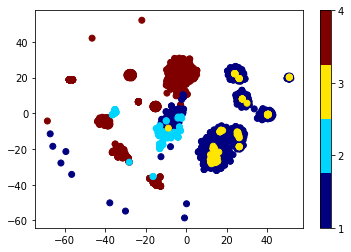

In [ ]:
tsne = TSNE().fit_transform(all_data.drop(['Class'], axis=1))

plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap=plt.cm.get_cmap("jet", 4))
plt.colorbar(ticks=range(5))
plt.show()

In [ ]:
X_cf_exemple = all_cf_second_class.drop(['Class'], axis=1)
y_pred_cf_exemple_class = best_xgb.predict(X_cf_exemple)
for i in range(len(y_pred_cf_exemple_class)):
    if y_pred_cf_exemple_class[i] != 2: 
        print("Wrong prediction for element {}:".format(i), y_pred_cf_exemple_class[i])

With the 9 classes:

In [ ]:
all_cf_first_class = pd.read_csv('/content/drive/MyDrive/Malware Visualization/Dataset/counterfactualsClass2To3.csv')
print('Number of counterfactual examples from class 2 to 3:', all_cf_first_class.shape)
all_cf_second_class = pd.read_csv('/content/drive/MyDrive/Malware Visualization/Dataset/counterfactualsClass3To2.csv')
print('Number of counterfactual examples from class 3 to 2:', all_cf_second_class.shape)
other_data = pd.read_csv('/content/drive/MyDrive/Malware Visualization/Dataset/completeFeaturesTrainDataset.csv')
print('Data size:', other_data.shape)

Number of counterfactual examples from class 2 to 3: (999, 260)
Number of counterfactual examples from class 3 to 2: (993, 260)
Data size: (10868, 261)


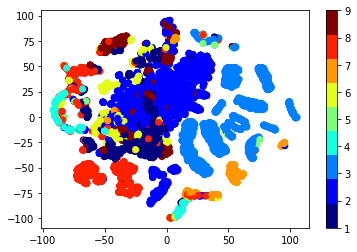

In [ ]:
# Clusters of all data
labels = other_data['Class']

tsne = TSNE().fit_transform(other_data.drop(['ID', 'Class'], axis=1))

plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.show()

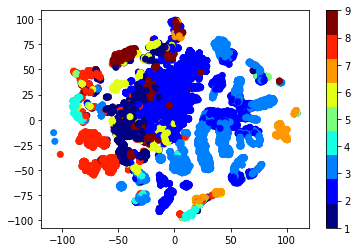

In [ ]:
# Clusters of all data + counterfactual examples
all_data = pd.concat([all_cf_first_class, all_cf_second_class,other_data.drop(['ID'], axis=1)])
all_data = all_data.sample(frac=1)
labels = all_data['Class']

tsne = TSNE().fit_transform(all_data.drop(['Class'], axis=1))

plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.show()

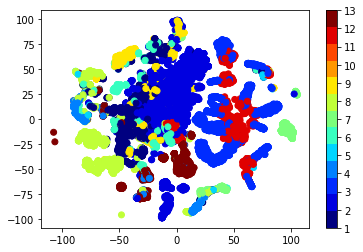

In [ ]:
# Clusters of all data + counterfactual examples in different colors
all_cf_first_class['Class'] = 13
all_cf_second_class['Class'] = 12
all_data = pd.concat([all_cf_first_class, all_cf_second_class,other_data.drop(['ID'], axis=1)])
all_data = all_data.sample(frac=1)
labels = all_data['Class']

tsne = TSNE().fit_transform(all_data.drop(['Class'], axis=1))

plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap=plt.cm.get_cmap("jet", 13))
plt.colorbar(ticks=range(14))
plt.show()